<a href="https://colab.research.google.com/github/TStephensCr/Cifar_10_separation/blob/main/cifar_10_separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Separazione di immagini Cifar10

Il modello prende in input una immagine ottenuta come media di due campioni random presi da Cifar10, e deve predirre le categorie delle due componenti.

La prima immagine appartiene alle prime 5 categorie (airplane, automobile, bird, cat, deer), mentre la seconda appartiene alle restanti (dog, frog, horse, ship, truck). Il modello deve restituire due label, ognuna in un range di 5 valori.

La metrica con cui valutare il modello è la seguente: calcolate l'accuratezza della classificazione per le due immagini componenti, e poi fatene la media.

La metrica deve essere valutata su 10000 input generati da dati di test. Ripetete il calcolo 10 volte e misurate la deviazione standard, che deve essere riportata.

Nel seguito si fornisce un generatore dei dati e qualche esempio.

#Preparazione dei dati

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Separiamo le immagini in due gruppi, in relazione alla loro etichetta.


In [ ]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Adesso possiamo definire il generatore. In input abbiamo due datasets (X1,X2), le etichette corrispondenti (Y1,Y2) e una batchsize.

Il generatore resituisce x_data, y_data, dove

*   x_data è una batch di immagini ottenute come media di campioni random in X1 and X2
*   y_data è una coppia di batch di etichette relative alle immagini componenti, espresse in formato categorico

In [ ]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  def augment_image(image): # Funzione di data augmentation, ottenuta ruotando le immagini
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.rot90(image, k=np.random.randint(0, 4))
    return image

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    x_data = np.array([augment_image(x).numpy() for x in x_data])
    y_data = [Y1_cat[num1],Y2_cat[num2]]

    yield x_data, y_data

Instanziamo un generatore su Cifar10 con batchsize=1, e testiamone il comportamento.

In [ ]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Generiamo un esempio, mostriamo l'immagine che deve essere presa in input dal modello, e stampiamo le categorie delle due componenti sovrapposte.

Potete rirpetere l'esecuzione della cella per mostrare nuovi esempi.

first: cat, second = truck


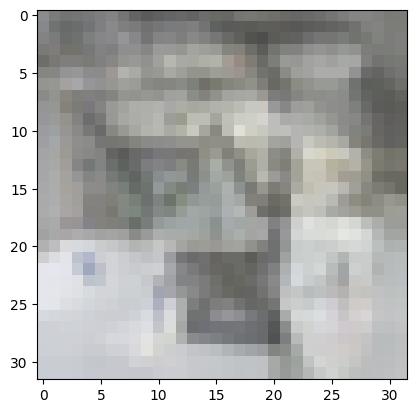

In [ ]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Valutazione

Dfiniamo innanzi tutto il generatore di testing.

In [ ]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


Segue il modello.

In [ ]:
def build_model():
    input_layer = layers.Input(shape=(32, 32, 3))

    # First convolutional block
    conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    norm1 = layers.BatchNormalization()(conv1)
    conv2 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(norm1)
    norm2 = layers.BatchNormalization()(conv2)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(norm2)

    # Second convolutional block
    conv3 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
    norm3 = layers.BatchNormalization()(conv3)
    conv4 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(norm3)
    norm4 = layers.BatchNormalization()(conv4)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(norm4)

    # Residual connection block
    shortcut = layers.Conv2D(128, kernel_size=(1, 1), strides=(1, 1), padding='same')(pool2)
    conv5 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    norm5 = layers.BatchNormalization()(conv5)
    conv6 = layers.Conv2D(128, kernel_size=(3, 3), activation=None, padding='same')(norm5)
    norm6 = layers.BatchNormalization()(conv6)
    add_layer = layers.Add()([norm6, shortcut])
    activation_layer = layers.ReLU()(add_layer)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(activation_layer)

    # Global pooling
    global_pool = layers.GlobalAveragePooling2D()(pool3)

    # Fully connected layers
    dense1 = layers.Dense(512, activation='relu')(global_pool)
    dropout_layer = layers.Dropout(0.5)(dense1)

    # Output layers
    out1 = layers.Dense(5, activation='softmax', name='class_output1')(dropout_layer)
    out2 = layers.Dense(5, activation='softmax', name='class_output2')(dropout_layer)

    # Model assembly and compilation
    net = Model(inputs=input_layer, outputs=[out1, out2])
    net.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=[['accuracy'], ['accuracy']]
    )

    return net

In [ ]:
# Funzione per richiamare e valutare il modello
def assess_model(trained_model):
    sample_inputs, sample_labels = next(testgen)
    predictions = trained_model(sample_inputs)
    acc1 = np.argmax(predictions[0], axis=1) == sample_labels[0][:, 0]
    acc2 = np.argmax(predictions[1], axis=1) == sample_labels[1][:, 0]
    return (np.mean(acc1) + np.mean(acc2)) / 2

In [ ]:
# Creazione e valutazione del modello
model_instance = build_model()
assess_model(model_instance)

# Aggiustamento dinamico del Learning Rate
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3, # Epoche senza miglioramenti necessarie per diminuire LR
    verbose=1,
    factor=0.3, # Fattore di diminuzione LR
    min_lr=1e-6 # Valore minimo LR
)

# Training del modello
training_history = model_instance.fit(
    cifar10_x_train, # Utilizziamo dati di training
    {
        'class_output1': tf.keras.utils.to_categorical(
            np.where(cifar10_y_train < 5, cifar10_y_train, 0), num_classes=5
        ),
        'class_output2': tf.keras.utils.to_categorical(
            np.where(cifar10_y_train >= 5, cifar10_y_train - 5, 0), num_classes=5
        )
    },
    epochs=20, #Ripetizioni
    batch_size=32,
    validation_data=(
        cifar10_x_test, # Dati di validazione/test
        {
            'class_output1': tf.keras.utils.to_categorical(
                np.where(cifar10_y_test < 5, cifar10_y_test, 0), num_classes=5
            ),
            'class_output2': tf.keras.utils.to_categorical(
                np.where(cifar10_y_test >= 5, cifar10_y_test - 5, 0), num_classes=5
            )
        }
    ),
    callbacks=[lr_scheduler]
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - class_output1_accuracy: 0.6209 - class_output1_loss: 0.9908 - class_output2_accuracy: 0.6677 - class_output2_loss: 0.8678 - loss: 1.8586 - val_class_output1_accuracy: 0.7190 - val_class_output1_loss: 0.7094 - val_class_output2_accuracy: 0.7925 - val_class_output2_loss: 0.5561 - val_loss: 1.2664 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - class_output1_accuracy: 0.7468 - class_output1_loss: 0.6472 - class_output2_accuracy: 0.8281 - class_output2_loss: 0.4655 - loss: 1.1127 - val_class_output1_accuracy: 0.7727 - val_class_output1_loss: 0.5908 - val_class_output2_accuracy: 0.8539 - val_class_output2_loss: 0.4023 - val_loss: 0.9937 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - class_output1_accuracy: 0.8046 - class_output1_loss: 0.5087 - class_output2_accuracy: 0.8719 - class_output2_loss: 0.3477 - loss: 0.8564 - val_class_output1_accuracy: 0.8079 - val_class_ou

let us repeat the evaluation ten times, and comput the standard deviation

In [ ]:
all_accuracies = []
random_indices = np.random.choice(cifar10_x_test.shape[0], 10000, replace=False) # Generazione dei 10000 input dai dati di test

# Eseguiamo il calcolo 10 volte
for run in range(10):
    print(f"Execution number {run + 1}/10")
    np.random.seed(run)

    sampled_x = cifar10_x_test[random_indices]

    sampled_y1 = tf.keras.utils.to_categorical(
        np.where(cifar10_y_test[random_indices] < 5, cifar10_y_test[random_indices], 0),
        num_classes=5
    )
    sampled_y2 = tf.keras.utils.to_categorical(
        np.where(cifar10_y_test[random_indices] >= 5, cifar10_y_test[random_indices] - 5, 0),
        num_classes=5
    )

    eval_results = model_instance.evaluate(
        sampled_x,
        {'class_output1': sampled_y1, 'class_output2': sampled_y2},
        verbose=0
    )

    acc_group1 = eval_results[3]
    acc_group2 = eval_results[4]
    avg_acc = (acc_group1 + acc_group2) / 2
    all_accuracies.append(avg_acc)

# Calcolo e output risultati
accuracy_mean = np.mean(all_accuracies)
accuracy_std = np.std(all_accuracies)

print("Valutazione delle accuracies:", all_accuracies)
print(f"Accuracy media: {accuracy_mean:.4f}")
print(f"Standard Deviation: {accuracy_std:.4f}")

Execution number 1/10
Execution number 2/10
Execution number 3/10
Execution number 4/10
Execution number 5/10
Execution number 6/10
Execution number 7/10
Execution number 8/10
Execution number 9/10
Execution number 10/10
Valutazione delle accuracies: [0.9039500057697296, 0.9039500057697296, 0.9039500057697296, 0.9039500057697296, 0.9039500057697296, 0.9039500057697296, 0.9039500057697296, 0.9039500057697296, 0.9039500057697296, 0.9039500057697296]
Accuracy media: 0.9040
Standard Deviation: 0.0000


# Cosa consegnare

Come di consueto, dovete consegnare un singolo notebook che deve essere eseguibile su colab. Il notebook deve essere adeguatamente commentato a contenere una traccia completa del training, come anche il calcolo della accuratezza secondo le direttive date sopra.

#Buon lavoro!